In [ ]:
using Pkg
Pkg.add("Interpolations")
Pkg.add("BasicInterpolators")

# We solve for stratified atmosphere
Given that $\vec{q}=\nabla(\tau)$ and $\vec{w}$ is the wind velocity vector, for a stratified atmosphere we obtain $$\dfrac{dq_x}{dt}=\dfrac{dq_y}{dt}=0;\dfrac{dq_z}{dt}=-q\dfrac{\partial c}{\partial z}-\vec{q}.\dfrac{\partial \vec{w}}{\partial z}$$ (Brouwer 2014). We implement a case of sound speed dependent on height with temperature: $$c_{air}=331 \dfrac{m}{s}\sqrt{\dfrac{T_{z=0m}-\dfrac{z}{300m}}{273.15 K}}$$ and a diagonal wind $$\vec{w_{z=1m}}=(5,5)$$ at 1 m height that varies with height following a Logarithmic model $$\vec{w}=\vec{w_{z=1m}}(1+ln(\dfrac{z}{1m})) \hspace{0.5cm}if \hspace{0.1cm} z\geq 1 $$ 

We obtain: $$\dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}q_z}{600*273.15*c(T,z)}-\dfrac{5(q_x+q_y)q_z}{z}$$

With $\dfrac{dt}{d\tau}=1$ and the initial condition $\tau(x,y,z=Source)=0$ we obtain $\tau=| \int \vec{q} d \vec{s} | \approx \Sigma |\vec{q_i}.\vec{\Delta {s_i}}  |  $ being s each differential element of the path traveled by the acoustic ray.

In [1]:
function v_wind_LogLaw(v_wind,z) # Wind profile
    v_wind_X=v_wind[1]*(1+log(z))
    v_wind_Y=v_wind[2]*(1+log(z))
    return v_wind_X, v_wind_Y
end
function c_air_TZ(T_z0,z)
    c_air=331*sqrt((T_z0+273.15-z/300)/273.15) # T_Z0 is entered in Celsius for convenience
    return c_air
end

c_air_TZ (generic function with 1 method)

We solve the ODE system: $\dfrac{dq_x}{dx}=\dfrac{dq_y}{dy}=0 ; \dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}q_z}{600*273.15*c(T,z)}-\dfrac{5(q_x+q_y)q_z}{z}$

In [2]:
@time begin
using DifferentialEquations
#Arguments and data
T=15.;
v_wind=[5.,5.,0.];

SourcePoint=[1.,1.,1.];
# The logarithmic wind model is reasonable up to not very high altitudes.
ReceiverPoint=[5001.,5001.,501.];

# We define the ODE system
function q!(dq, q, p, z)
    c=c_air_TZ(p[1],z)
    dq[1]=0
    dq[2]=0
    dq[3] = 331^2*sqrt(q[1]^2 + q[2]^2 + q[3]^2)*q[3] / (600 * 273.15 *c) - 5*(q[1]+q[2])*q[3]/z
end
theta=rad2deg(acos(500/sqrt(2*5000^2+500^2)))
phi=45 # Calculated both directly.
# We define the initial conditions and parameters.
q0=1/(c_air_TZ(T, SourcePoint[3])+(v_wind[1]*cosd(phi)+v_wind[2]*sind(phi))*sind(theta))
q_x = q0*cosd(phi)*sind(theta)
q_y = q0*sind(phi)*sind(theta)
q_z = q0*cosd(theta)
u0 = [q_x, q_y, q_z]


# We define the range of z values. We must be careful when optimizing, given
# that if any optimized value (z coordinate) is outside of zspan we cannot evaluate it.
zspan = (SourcePoint[3], ReceiverPoint[3])

# We define the parameters.
p = [T] 

# We define the ODE problem.
prob = ODEProblem(q!, u0, zspan, p)

# We solve the ODE problem storing in the Z values that correspond to the intersections of the segments.
sol = solve(prob, RK4(),dt=1e-3)

# We save the values of vec(q).
qx_vals=zeros(length(sol.u))
qy_vals=zeros(length(sol.u))
qz_vals=zeros(length(sol.u))

for i in 1:length(sol.u)
    qx_vals[i]=sol.u[i][1]
    qy_vals[i]=sol.u[i][2]
    qz_vals[i]=sol.u[i][3]
end
#########################
end

 29.804555 seconds (24.28 M allocations: 1.703 GiB, 3.83% gc time, 10.15% compilation time: 2% of which was recompilation)


In [3]:
#Interpolate
using Interpolations
###### qx and qy are constants
qx=sum(qx_vals)/length(qx_vals)
######
qy=sum(qy_vals)/length(qy_vals)
######
# We interpolate to obtain qz(z) in every z between the source and the receiver. Here we use Cubic Splines
z_values_cubic = range(SourcePoint[3], stop=ReceiverPoint[3], length=length(qz_vals))
qz_z_cubic=CubicSplineInterpolation(z_values_cubic, qz_vals);

In [4]:
using DifferentialEquations

function Hamiltonian_c(qx::Float64,qy::Float64,qz_z_cubic, SegmentsCoords::Array{Float64, 2})
   
    # We calculate the traveltime between each segment taking the average of the q's between each segment 
    #(Trapezoid rule approximation)
    taus=zeros(length(SegmentsCoords[:,1])-1)
    for i in 1:(length(SegmentsCoords[:,1])-1)
        # qx and qy are constants, it doesn't matter which element of the vector we take.
        aux_x=(SegmentsCoords[i+1,1]-SegmentsCoords[i,1])
        aux_y=(SegmentsCoords[i+1,2]-SegmentsCoords[i,2])
        #The interpolation function can extrapolate slightly outside the data range.
        #We must use  clamp() to ensure it interpolates within the range.
        z1 = clamp(SegmentsCoords[i,3], SegmentsCoords[1,3], SegmentsCoords[end,3])
        z2 = clamp(SegmentsCoords[i+1,3], SegmentsCoords[1,3], SegmentsCoords[end,3])
        aux_z=(SegmentsCoords[i+1,3]-SegmentsCoords[i,3])
        q_m=sqrt(qx^2+qy^2+(qz_z_cubic(z1)+qz_z_cubic(z2))^2/4)
        taus[i]=q_m*sqrt(aux_x^2+aux_y^2+aux_z^2)
    end
    
   # We add up the traveltime of each segment to get the total.
    total_travel_time = sum(taus)
        
    return total_travel_time
end

Hamiltonian_c (generic function with 1 method)

# Note

We see that qz decreases quite a bit as the height increases. It is reasonable for the optimizer to then concentrate the greatest number of points around the receiver. This is not realistic for the representation of a curve. Therefore, a penalty will be imposed if the points are not evenly spaced.

In [11]:
@time begin
using Optim
using Statistics
    
# We optimize the coordinates of the intersections between segments.
function objective(SegmentsCoords)
    # First, we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian_c(qx, qy, qz_z_cubic, FullSegmentsCoords)

    # We calculate the distances between consecutive segments
    segment_distances = diff(FullSegmentsCoords, dims=1)

    # We calculate the standard deviation of the distances
    distance_std_normalized = Statistics.std(segment_distances)/(ReceiverPoint[3]-SourcePoint[3])

    # We add a penalty to the objective function based on the standard deviation of the distances
    return traveltime + distance_std_normalized
end


# Piecewise straight line from the source to the receiver as initial condition.
num_segments=10;
initial_SegmentsCoords = zeros(num_segments-1, 3); 
for i in 1:num_segments-1
    alpha = i / num_segments
    initial_SegmentsCoords[i, :] = SourcePoint + alpha * (ReceiverPoint - SourcePoint) 
end
# We have to take "box" constraints so that the optimized z values (SegmentsCoords[:,3]) 
# are not outside the solution interval (zspan)
lower_bounds = fill(SourcePoint[1], size(initial_SegmentsCoords))
upper_bounds = fill(ReceiverPoint[1], size(initial_SegmentsCoords))
lower_bounds[:, 3] .= 0.
upper_bounds[:, 3] .= 1001.


# Internal optimizer. Limited-memory Broyden-Fletcher-Goldfarb-Shanno
# which is a second-order optimization method valid for minimizing non-linear functions.
inner_optimizer = LBFGS()

#Optimizer with the "box" constraints.
optimizer_with_constraints = Fminbox(inner_optimizer)

# We optimize with the constraints
result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)

# Result of the optimization
Optimal_SegmentsCoords = result.minimizer;
    
# We include the source and the receiver in the optimized coordinates
Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
    
# We evaluate the traveltime for the optimized trajectory
traveltime =Hamiltonian_c(qx, qy, qz_z_cubic, Full_Optimal_SegmentsCoords)
println("The total travel time for the segmented trajectory is: ", traveltime, " seconds")
end

println("Iteraciones realizadas: ", result.iterations)
println("Evaluaciones de la función: ", result.f_calls)



The total travel time for the segmented trajectory is: 20.422414417482724 seconds
  0.555365 seconds (1.80 M allocations: 134.125 MiB, 19.65% gc time, 32.37% compilation time: 100% of which was recompilation)
Iteraciones realizadas: 2
Evaluaciones de la función: 1752


In [12]:
Full_Optimal_SegmentsCoords

11×3 Matrix{Float64}:
    1.0       1.0      1.0
  500.887   500.887   53.2959
 1000.8    1000.8    105.418
 1500.74   1500.74   157.033
 2000.68   2000.68   208.032
 2500.67   2500.67   258.391
 3000.69   3000.69   308.112
 3500.74   3500.74   357.21
 4000.82   4000.82   405.707
 4500.92   4500.92   453.63
 5001.0    5001.0    501.0

In [13]:
@time begin
using Optim
using Statistics
#Same arguments and data, stored in the previous notebooks
    
#We optimize the coordinates of the intersections between segments.
function objective(SegmentsCoords)
    # First, we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords.
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian_c(qx, qy, qz_z_cubic, FullSegmentsCoords)

     # We calculate the distances between consecutive segments
    segment_distances = diff(FullSegmentsCoords, dims=1)

    # We calculate the standard deviation of the distances
    distance_std_normalized = Statistics.std(segment_distances)/(ReceiverPoint[3]-SourcePoint[3])

    # We add a penalty to the objective function based on the standard deviation of the distances
    return traveltime + distance_std_normalized
end

# We define a matrix of matrices Plot_Coords the size of the loop, or higher, to then plot the distance of the points to a line.
Plot_Coords = Matrix{Matrix{Float64}}(undef, 10, 1)

# We iterate the initial condition.
initial_SegmentsCoords = zeros(1, 3); #c.i.
for i in 1:6
    if i == 1
        initial_SegmentsCoords[1, :] = SourcePoint + (ReceiverPoint - SourcePoint) / 2
    end
        
    lower_bounds = fill(0., size(initial_SegmentsCoords))
    upper_bounds = fill(6000., size(initial_SegmentsCoords))
    lower_bounds[:, 3] .= 0.
    upper_bounds[:, 3] .= 1000.

    inner_optimizer = LBFGS()
    optimizer_with_constraints = Fminbox(inner_optimizer)
    result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)
    Optimal_SegmentsCoords = result.minimizer;
    Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
        
    # We store the coordinates of the optimization including the source and the receiver for later plotting.
    Plot_Coords[i]=Full_Optimal_SegmentsCoords
    
    # We evaluate the traveltime for the different number of segments proposed.
    total_time = Hamiltonian_c(qx, qy, qz_z_cubic, Full_Optimal_SegmentsCoords)
    println("Num segments: ", Int(size(Full_Optimal_SegmentsCoords, 1) - 1), ". Traveltime:", total_time, " s")
    println("Iteraciones realizadas: ", result.iterations, ". Evaluaciones de la función: ", result.f_calls)
        

    copy_Optimal_SegmentsCoords = zeros(2 * size(Optimal_SegmentsCoords, 1) + 1, 3)
    
    # We calculate copy_optimal_SegmentsCoords   
    for j in 1:2 * size(Optimal_SegmentsCoords, 1) + 1
        if j==1
            copy_Optimal_SegmentsCoords[j,:]=(SourcePoint+Optimal_SegmentsCoords[1,:])/2
        elseif j==2*size(Optimal_SegmentsCoords,1)+1
            copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[end,:]+ReceiverPoint)/2
        else
            if iseven(j)
                copy_Optimal_SegmentsCoords[j,:]=Optimal_SegmentsCoords[Int(j/2),:]
            else
                copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[Int((j-1)/2),:]+Optimal_SegmentsCoords[Int((j+1)/2),:])/2
            end
        end
    end
    # Here we iterate the initial condition.
    initial_SegmentsCoords = copy(copy_Optimal_SegmentsCoords)
end
end




Num segments: 2. Traveltime:20.422166899452765 s
Iteraciones realizadas: 2. Evaluaciones de la función: 38
Num segments: 4. Traveltime:20.422353964672563 s
Iteraciones realizadas: 1. Evaluaciones de la función: 74
Num segments: 8. Traveltime:20.422411788947883 s
Iteraciones realizadas: 1. Evaluaciones de la función: 735
Num segments: 16. Traveltime:20.422414321460064 s
Iteraciones realizadas: 2. Evaluaciones de la función: 2479
Num segments: 32. Traveltime:20.42241587827463 s
Iteraciones realizadas: 1. Evaluaciones de la función: 1207
Num segments: 64. Traveltime:20.422416260634776 s
Iteraciones realizadas: 1. Evaluaciones de la función: 1380
  7.015593 seconds (17.77 M allocations: 3.683 GiB, 11.68% gc time, 2.55% compilation time: 100% of which was recompilation)


In [14]:
using Plots 

# We define the names of the labels and shapes for each number of segments
labels = ["2 segments", "4 segments", "8 segments", "16 segments", "32 segments", "64 segments", "128 segments", "256 segments", "512 segments"]
shapes = [:diamond, :square, :star6, :octagon, :circle, :star4, :star5, :octagon, :circle]

plot(legend=:topleft)

# We iterate over each set of segment coordinates
for i in 1:6
    z = Plot_Coords[i][:, 3]
    aux = sqrt.((Plot_Coords[i][:, 1]/10-Plot_Coords[i][:, 3]).^2+(Plot_Coords[i][:, 2]/10-Plot_Coords[i][:, 3]).^2)
    aux[1] = aux[end] = 0.
    plot!(z, aux, label=labels[i], shape=shapes[i])
end

xlabel!("z (m)")
ylabel!("Deviation to a straight line (m)")
#savefig("name.png")

"C:\\Users\\Miguel\\Desktop\\TFM\\Codigos Julia\\TrayectoriaWvarSpatialGradient.png"

In [9]:
Plot_Coords[4] #Coordinates of 16 segments

17×3 Matrix{Float64}:
    1.0       1.0      1.0
  313.436   313.436   33.7333
  625.902   625.902   66.4646
  938.366   938.366   99.0613
 1250.83   1250.83   131.461
 1563.3    1563.3    163.628
 1875.77   1875.77   195.543
 2188.26   2188.26   227.201
 2500.76   2500.76   258.601
 2813.26   2813.26   289.745
 3125.77   3125.77   320.635
 3438.29   3438.29   351.277
 3750.82   3750.82   381.677
 4063.36   4063.36   411.84
 4375.9    4375.9    441.773
 4688.46   4688.46   471.491
 5001.0    5001.0    501.0

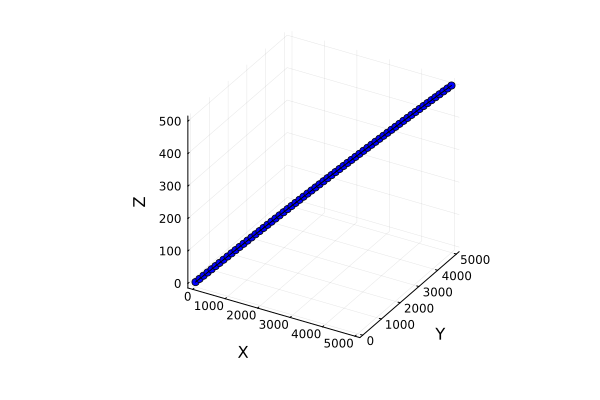

In [10]:
#We plot the trajectory 
using Plots
plot()

x_coords = Plot_Coords[6][:, 1]
y_coords = Plot_Coords[6][:, 2]
z_coords = Plot_Coords[6][:, 3]

scatter!(x_coords, y_coords, z_coords, marker=:circle, color=:blue, legend=false)
for i in 1:length(x_coords)-1
    plot!([x_coords[i], x_coords[i+1]], [y_coords[i], y_coords[i+1]], [z_coords[i], z_coords[i+1]], color=:black, linewidth=1)
end

xlabel!("X")
ylabel!("Y")
zlabel!("Z")